<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 2
<br>
<b>Deadline:</b> May 23, 2020 (Monday). 23:00
</div>

# Exercise 11.1. Generative adversarial networks (GANs). DCGAN: Deep convolutional GAN

The goal of this exercise is to get familiar with generative adversarial networks and specifically DCGAN. The model was proposed by [Radford et al., 2015](https://arxiv.org/pdf/1511.06434.pdf).

DCGAN is probably the simplest GAN model which is relatively easy to train.

In [33]:
skip_training = True  # Set this flag to True before validation and submission

In [34]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms

import tools
import tests

In [36]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [37]:
device = torch.device('cuda:0')
#device = torch.device('cpu')

In [38]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

# Data

We will use MNIST data in this exercise.

In [39]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)

batch_size = 100
data_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Generative adversarial networks

Our task is to train a generative model of the data, that is a model from which we can draw samples that will have a distribution similar to the distribution of the training data (MNIST digits in our case).

## Generator

The generative model that we are going to train is:
\begin{align}
z &\sim N(0, I)
\\
x &= G(z)
\end{align}
that is the data is generated by applying a nonlinear transformation to samples drawn from the standard normal distribution.

We are going to model $G$ with a deep neural network created below. In DCGAN, the generator is made of only transposed convolutional layers `ConvTranspose2d`.
The proposed architecture for the generator:
* `ConvTranspose2d` layer with `kernel_size=4`, `stride=2`, `4*ngf` output channels, no bias,
   followed by `BatchNorm2d` and ReLU
* `ConvTranspose2d` layer with `kernel_size=4`, `stride=2`, `2*ngf` output channels, no bias,
   followed by `BatchNorm2d` and ReLU
* `ConvTranspose2d` layer with `kernel_size=4`, `stride=2`, `ngf` output channels, no bias,
   followed by `BatchNorm2d` and ReLU
* `ConvTranspose2d` layer with `kernel_size=4`, `stride=2`, `nc` output channels, no bias,
   followed by `tanh`.
   
The `tanh` nonlinearity guarantees that the output is between 0 and 1 which holds for MNIST digits.

**The exact architecture is not tested in this assignment. If the description is not full, please fill the missing pieces according to your preferences.**

In [40]:
class Generator(nn.Module):
    def __init__(self, nz=10, ngf=64, nc=1):
        """GAN generator.
        
        Args:
          nz:  Number of elements in the latent code.
          ngf: Base size (number of channels) of the generator layers.
          nc:  Number of channels in the generated images.
        """
        super(Generator, self).__init__()
        # YOUR CODE HERE
        self.c1 = nn.Sequential(
            nn.ConvTranspose2d(nz, 4 * ngf, 4, stride=2, padding=0),
            nn.BatchNorm2d(4 * ngf),
            nn.ReLU(True),
        )
        self.c2 = nn.Sequential(
            nn.ConvTranspose2d(4 * ngf, 2 * ngf, 4, stride=2, padding=1),
            nn.BatchNorm2d(2 * ngf),
            nn.ReLU(True)
        )
        self.c3 = nn.Sequential(
            nn.ConvTranspose2d(2 * ngf, ngf, 4, stride=2, padding=2),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
        )
        self.c4 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, verbose=False):
        """Generate images by transforming the given noise tensor.
        
        Args:
          z of shape (batch_size, nz, 1, 1): Tensor of noise samples. We use the last two singleton dimensions
                          so that we can feed z to the generator without reshaping.
          verbose (bool): Whether to print intermediate shapes (True) or not (False).
        
        Returns:
          out of shape (batch_size, nc, 28, 28): Generated images.
        """
        # YOUR CODE HERE
        a = z
        a = self.c1(a)
        if verbose:
            print(a.shape)
        a = self.c2(a)
        if verbose:
            print(a.shape)
        a = self.c3(a)
        if verbose:
            print(a.shape)
        a = self.c4(a)
        if verbose:
            print(a.shape)
        return a

In [41]:
def test_Generator_shapes():
    nz = 10
    netG = Generator(nz, ngf=64, nc=1)

    batch_size = 32
    noise = torch.randn(batch_size, nz, 1, 1)
    out = netG(noise, verbose=True)

    assert out.shape == torch.Size([batch_size, 1, 28, 28]), f"Bad shape of out: out.shape={out.shape}"
    print('Success')

test_Generator_shapes()

torch.Size([32, 256, 4, 4])
torch.Size([32, 128, 8, 8])
torch.Size([32, 64, 14, 14])
torch.Size([32, 1, 28, 28])
Success


### Loss for training the generator

The generative model will be guided by a discriminator whose task is to separate (classify) data into two classes:
* true data (samples from the training set)
* generated data (samples generated by the generator).

In [42]:
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

The task of the generator is to confuse the discriminator as much as possible, which is the case when the distribution produced by the generator perfectly replicates the data distribution.

In the cell below, you need to implement the loss function which is used to train the generator. The loss should be the `binary_cross_entropy` loss computed with `real_label` as targets for the generated samples.

In [43]:
def generator_loss(D, fake_images):
    """Loss computed to train the GAN generator.

    Args:
      D: The discriminator whose forward function takes inputs of shape (batch_size, nc, 28, 28)
         and produces outputs of shape (batch_size, 1).
      fake_images of shape (batch_size, nc, 28, 28): Fake images produces by the generator.

    Returns:
      loss: The sum of the binary cross-entropy losses computed for all the samples in the batch.

    Notes:
    - Make sure that you process on the device given by `fake_images.device`.
    - Use values of global variables `real_label`, `fake_label` to produce the right targets.
    """
    # YOUR CODE HERE
    d = D(fake_images)
    ff = torch.tensor([real_label], dtype=torch.float32).to(fake_images.device)
    targets = ff.repeat((fake_images.shape[0]))
    return F.binary_cross_entropy(d, targets)

In [44]:
tests.test_generator_loss(generator_loss)

loss: tensor(1.0730)
expected: tensor(1.0730)
Success


## Discriminator

In DCGAN, the discriminator is a stack of only convolutional layers.

The proposed architecture for the discriminator:
* `Conv2d` layer with `kernel_size=4`, `stride=2`, `ndf` output channels, no bias,
   followed by LeakyReLU(0.2)
* `Conv2d` layer with `kernel_size=4`, `stride=2`, `2*ndf` output channels, no bias,
   followed by LeakyReLU(0.2)
* `Conv2d` layer with `kernel_size=4`, `stride=2`, `4*ndf` output channels, no bias,
   followed by LeakyReLU(0.2)
* `Conv2d` layer with `kernel_size=4`, `stride=2`, `nc` output channels, no bias,
   followed by `sigmoid`.

**The exact architecture is not tested in this assignment. If the description is not full, please fill the missing pieces according to your preferences.**

In [45]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        """GAN discriminator.
        
        Args:
          nc:  Number of channels in images.
          ndf: Base size (number of channels) of the discriminator layers.
        """
        # YOUR CODE HERE
        super(Discriminator, self).__init__()
        self.c1 = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )
        self.c2 = nn.Sequential(
            nn.Conv2d(ndf, 2 * ndf, 4, stride=2, padding=2),
            nn.LeakyReLU(0.2),
        )
        self.c3 = nn.Sequential(
            nn.Conv2d(2 * ndf, 4 * ndf, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )
        self.c4 = nn.Sequential(
            nn.Conv2d(4 * ndf, nc, 4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x, verbose=False):
        """Classify given images into real/fake.
        
        Args:
          x of shape (batch_size, 1, 28, 28): Images to be classified.
        
        Returns:
          out of shape (batch_size,): Probabilities that images are real. All elements should be between 0 and 1.
        """
        # YOUR CODE HERE
        x = self.c1(x)
        if verbose:
            print(x.shape)
        x = self.c2(x)
        if verbose:
            print(x.shape)
        x = self.c3(x)
        if verbose:
            print(x.shape)
        x = self.c4(x)
        if verbose:
            print(x.shape)
        return x.squeeze()

In [46]:
def test_Discriminator_shapes():
    batch_size = 32
    netD = Discriminator(nc=1, ndf=64)

    images = torch.ones(32, 1, 28, 28)
    out = netD(images, verbose=True)

    assert out.shape == torch.Size([batch_size]), f"Bad shape of out: out.shape={out.shape}"
    print('Success')

test_Discriminator_shapes()

torch.Size([32, 64, 14, 14])
torch.Size([32, 128, 8, 8])
torch.Size([32, 256, 4, 4])
torch.Size([32, 1, 1, 1])
Success


### Loss for training the discriminator

The discriminator is trained to solve a binary classification problem: to separate real data from generated samples. Thus, the output of the discriminator should be a scalar between 0 and 1.

You need to implement the loss function used to train the discriminator. The dicriminator uses the `binary_cross_entropy` loss using `real_label` as targets for real samples and `fake_label` as targets for generated samples.

In [47]:
def discriminator_loss(D, real_images, fake_images):
    """Loss computed to train the GAN discriminator.

    Args:
      D: The discriminator.
      real_images of shape (batch_size, nc, 28, 28): Real images.
      fake_images of shape (batch_size, nc, 28, 28): Fake images produces by the generator.

    Returns:
      d_loss_real: The mean of the binary cross-entropy losses computed on the real_images.
      D_real: Mean output of the discriminator for real_images. This is useful for tracking convergence.
      d_loss_fake: The mean of the binary cross-entropy losses computed on the fake_images.
      D_fake: Mean output of the discriminator for fake_images. This is useful for tracking convergence.

    Notes:
    - Make sure that you process on the device given by `fake_images.device`.
    - Use values of global variables `real_label`, `fake_label` to produce the right targets.
    """
    # YOUR CODE HERE
    d_f = D(fake_images)
    d_r = D(real_images)
    ff = torch.tensor([fake_label], dtype=torch.float32).to(fake_images.device)
    t_f = ff.repeat((fake_images.shape[0]))
    rr = torch.tensor([real_label], dtype=torch.float32).to(real_images.device)
    t_r = rr.repeat((real_images.shape[0]))
    d_loss_fake = F.binary_cross_entropy(d_f, t_f)
    d_loss_real = F.binary_cross_entropy(d_r, t_r)
    D_real = d_r.mean()
    D_fake = d_f.mean()
    return d_loss_real, D_real, d_loss_fake, D_fake

In [48]:
def test_discriminator_loss():
    netD = Discriminator(nc=1, ndf=64)
    real_images = fake_images = torch.ones(32, 1, 28, 28)

    d_loss_real, D_real, d_loss_fake, D_fake = discriminator_loss(netD, real_images, fake_images)
    assert d_loss_real.shape == torch.Size([]), "d_loss_real should be a scalar tensor."
    assert 0 < D_real < 1, "D_real should be a scalar between 0 and 1."
    assert d_loss_fake.shape == torch.Size([]), "d_loss_fake should be a scalar tensor."
    assert 0 < D_fake < 1, "D_fake should be a scalar between 0 and 1."
    print('Success')

test_discriminator_loss()

Success


In [49]:
tests.test_discriminator_loss(discriminator_loss)

d_loss_real: tensor(0.3635)
expected d_loss_real: tensor(0.3635)
D_real: tensor(0.7000)
expected D_real: 0.699999988079071
d_loss_fake: 0.22839301824569702
expected d_loss_fake: tensor(0.2284)
D_fake: tensor(0.2000)
expected D_fake: 0.20000000298023224
Success


# Training GANs

We will now train a GAN. To assess the quality of the generated samples, we will use a simple scorer loaded in the cell below.

In [50]:
from scorer import Scorer
scorer = Scorer()
scorer.to(device)

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


Scorer(
  (model): MLP(
    (model): Sequential(
      (fc1): Linear(in_features=784, out_features=256, bias=True)
      (relu1): ReLU()
      (drop1): Dropout(p=0.2, inplace=False)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (relu2): ReLU()
      (drop2): Dropout(p=0.2, inplace=False)
      (out): Linear(in_features=256, out_features=10, bias=True)
    )
  )
)

In [51]:
# Create the network
nz = 10
netG = Generator(nz=nz, ngf=64, nc=1)
netD = Discriminator(nc=1, ndf=64)

netD = netD.to(device)
netG = netG.to(device)

### Training loop

Implement the training loop in the cell below. The recommended hyperparameters:
* Optimizer of the discriminator: Adam with learning rate 0.0002 and `betas=(0.5, 0.999)`
* Optimizer of the generator:     Adam with learning rate 0.0002 and `betas=(0.5, 0.999)`

Hints:
- We will use the scorer defined above to assess the quality of the generated samples. The desired level of .7 should be reached within 15-20 epochs.
- You can use the following code to track the training progress. The code plots some generated images and computes the score that we use to evaluate the trained model. Note that the images fed to the scorer need to be normalized to be in the range [0, 1].
```
with torch.no_grad():
    # Plot generated images
    z = torch.randn(144, nz, 1, 1, device=device)
    samples = netG(z)
    tools.plot_generated_samples(samples)
    
    # Compute score
    z = torch.randn(1000, nz, 1, 1, device=device)
    samples = netG(z)
    samples = (samples + 1) / 2  # Re-normalize to [0, 1]
    score = scorer(samples)
```
- The quality of the generated images should be good (better than with the PixelCNN model).
- You can track `D_real` and `D_fake` returned by function `discriminator_loss()`. When it is hard for the discriminator to separate real and fake images, their values are close to 0.5.

epoch: 0
Loss: 0.403977, 0.598651, D_real: 0, D_fake: 0


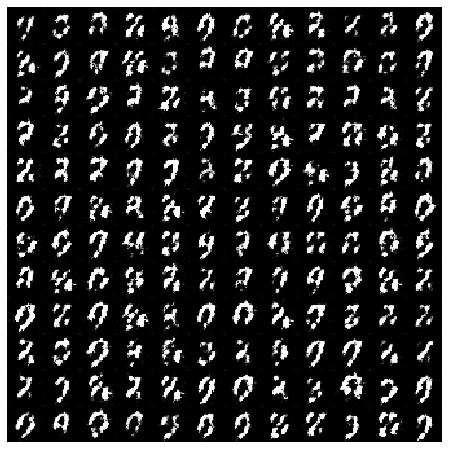

Score: 0.498092
epoch: 1
Loss: 0.540574, 0.685792, D_real: 0, D_fake: 0


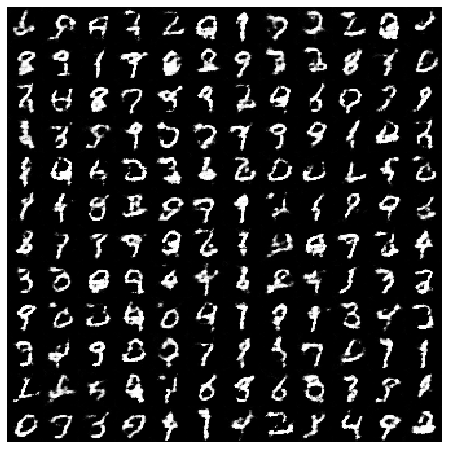

Score: 0.552709
epoch: 2
Loss: 0.688896, 0.631140, D_real: 0, D_fake: 0


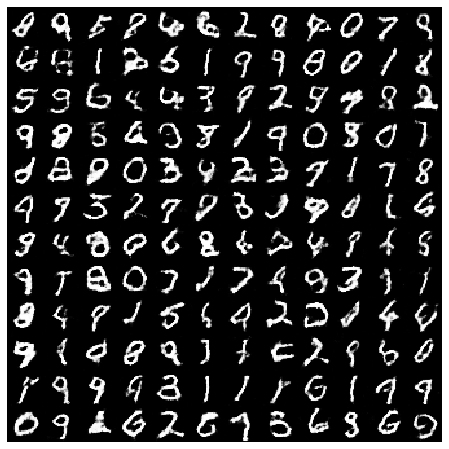

Score: 0.585215
epoch: 3
Loss: 0.715591, 0.586577, D_real: 0, D_fake: 0


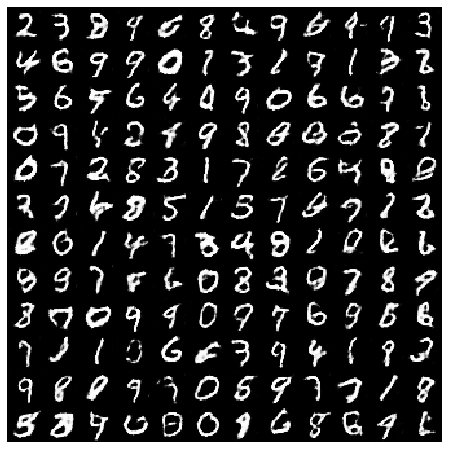

Score: 0.615163
epoch: 4
Loss: 0.626756, 0.651434, D_real: 0, D_fake: 0


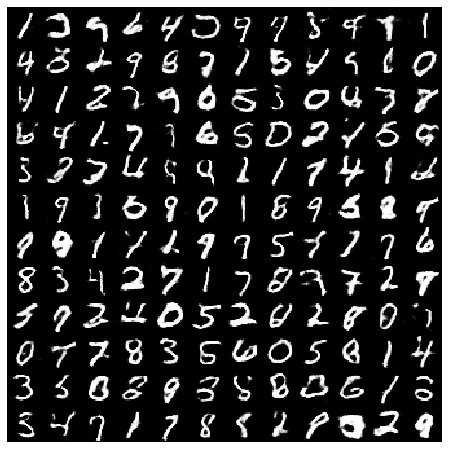

Score: 0.644698
epoch: 5
Loss: 0.729525, 0.540850, D_real: 0, D_fake: 0


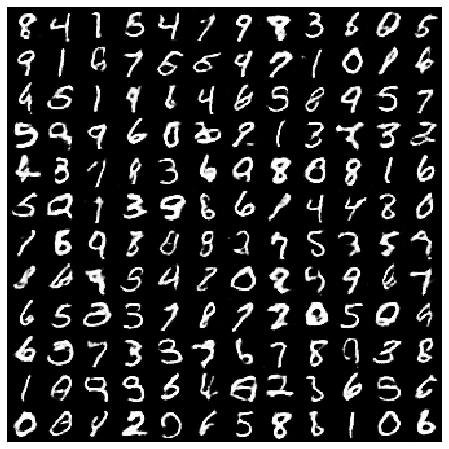

Score: 0.681413
epoch: 6
Loss: 0.564329, 0.765540, D_real: 0, D_fake: 0


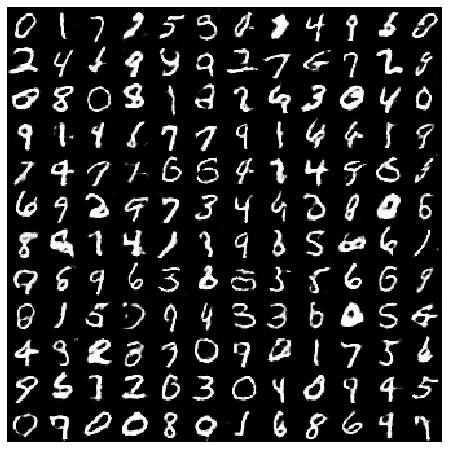

Score: 0.674979
epoch: 7
Loss: 0.721003, 0.648280, D_real: 0, D_fake: 0


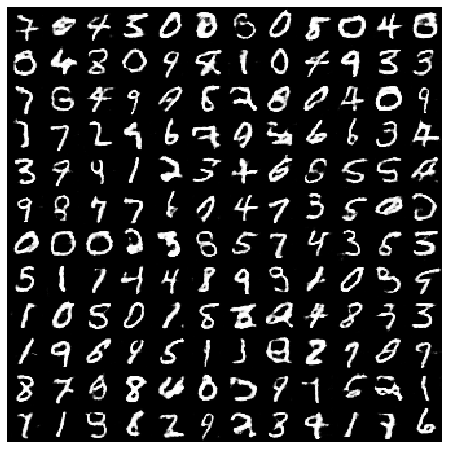

Score: 0.714649
epoch: 8
Loss: 0.644734, 0.647089, D_real: 0, D_fake: 0


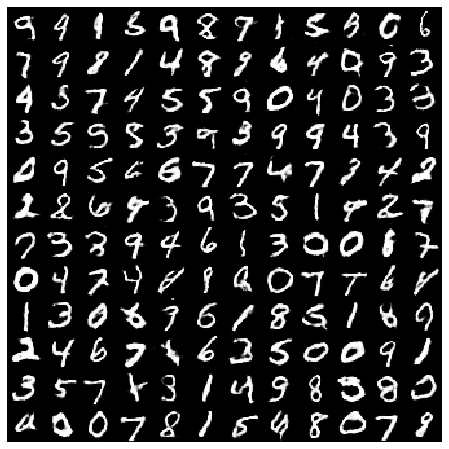

Score: 0.700608
epoch: 9
Loss: 0.634158, 0.729509, D_real: 0, D_fake: 0


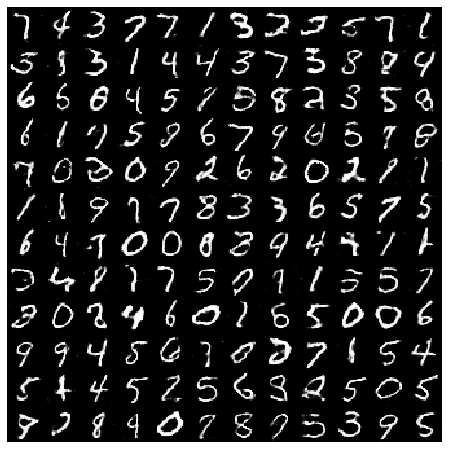

Score: 0.650439
epoch: 10
Loss: 0.812240, 0.581985, D_real: 0, D_fake: 0


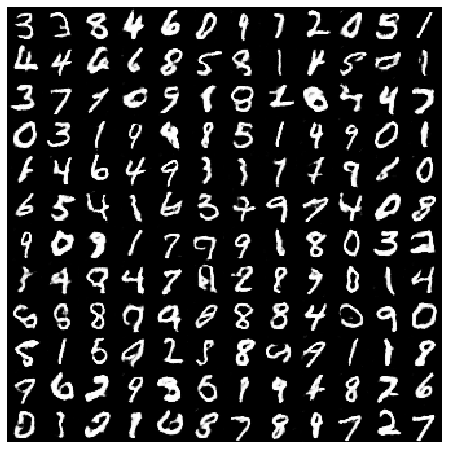

Score: 0.735155
epoch: 11
Loss: 0.778528, 0.585312, D_real: 0, D_fake: 0


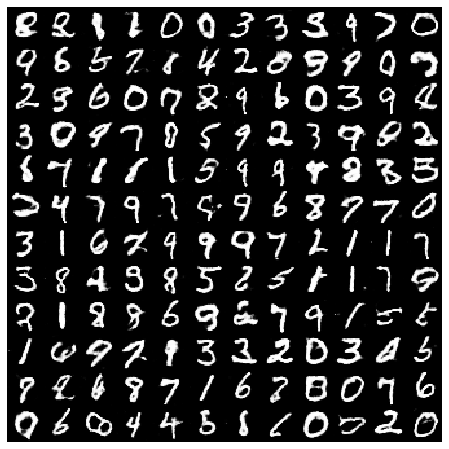

Score: 0.746172
epoch: 12
Loss: 0.774111, 0.526319, D_real: 0, D_fake: 0


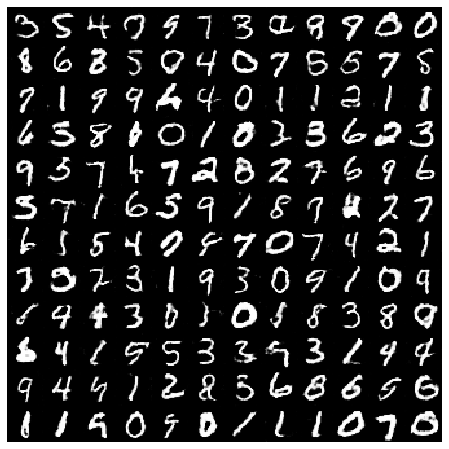

Score: 0.720041
epoch: 13
Loss: 0.653585, 0.754115, D_real: 0, D_fake: 0


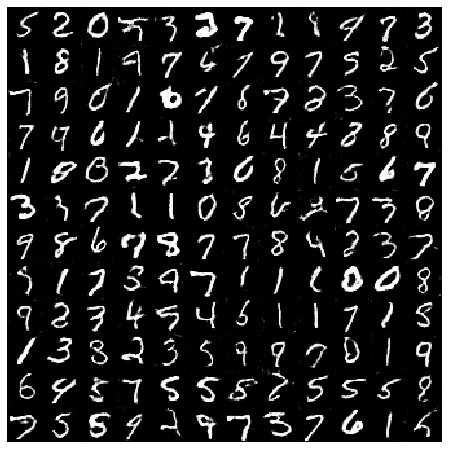

Score: 0.682442
epoch: 14
Loss: 0.723141, 0.611399, D_real: 0, D_fake: 0


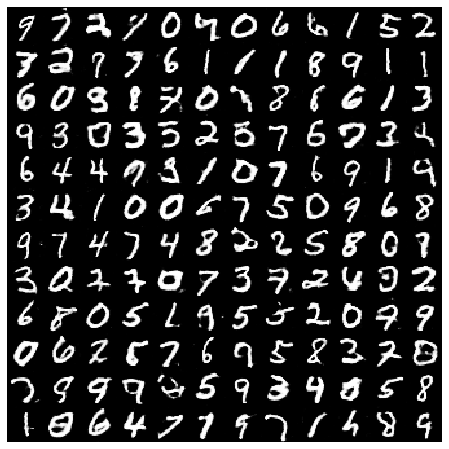

Score: 0.768426
epoch: 15
Loss: 0.461862, 0.796652, D_real: 0, D_fake: 0


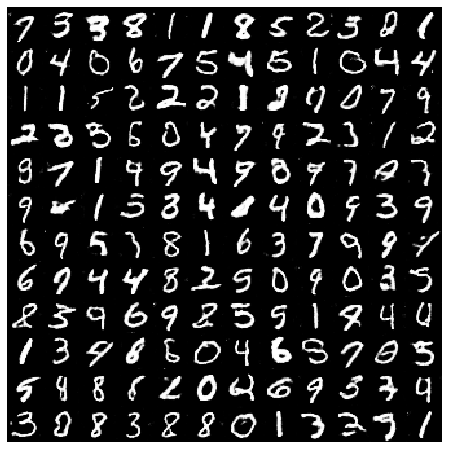

Score: 0.743585
epoch: 16
Loss: 0.660227, 0.661629, D_real: 0, D_fake: 0


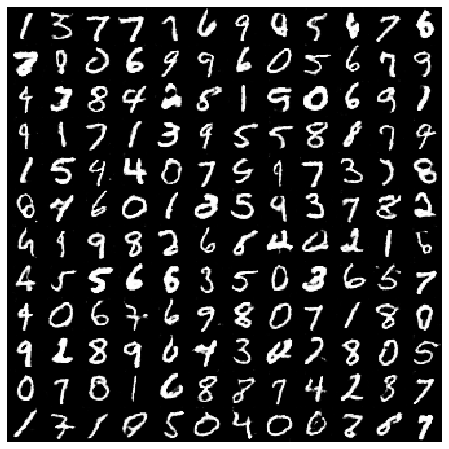

Score: 0.756526
epoch: 17
Loss: 0.461993, 0.872328, D_real: 0, D_fake: 0


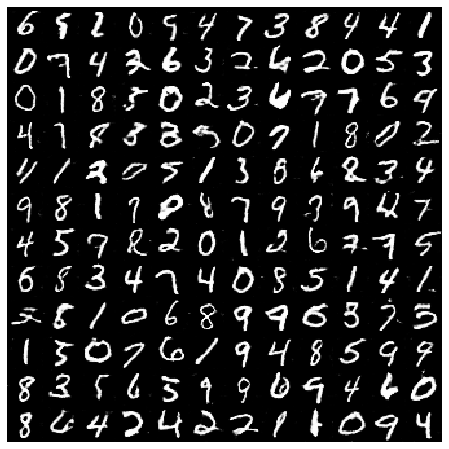

Score: 0.731782
epoch: 18
Loss: 0.700611, 0.581136, D_real: 0, D_fake: 0


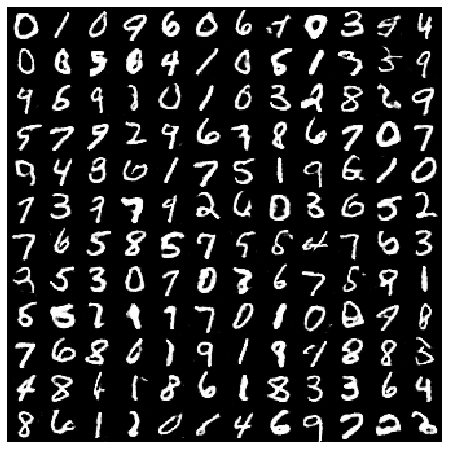

Score: 0.771509
epoch: 19
Loss: 0.450842, 0.840930, D_real: 0, D_fake: 0


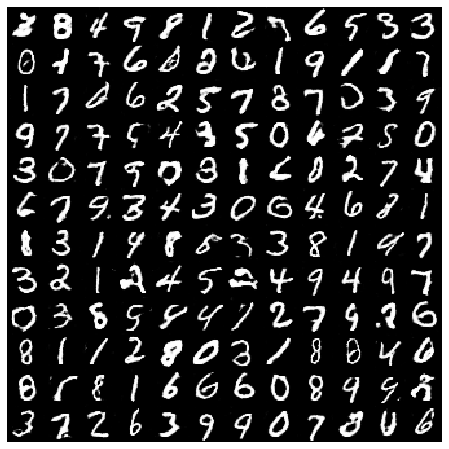

Score: 0.767872


In [54]:
if not skip_training:
    # YOUR CODE HERE
    optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(.5, .999))
    optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(.5, .999))
    criterion = nn.BCELoss()
    for i in range(20):
        print("epoch: %d" % i)
        for i_batch, data in enumerate(data_loader):
            data = data[0]
            netD.zero_grad()
            netG.zero_grad()
            data = data.to(device)
            b_size = data.shape[0]
            noise = torch.randn(b_size, nz, 1, 1, device=device)

            fake = netG(noise)
            d_loss_real, D_real, d_loss_fake, D_fake = discriminator_loss(netD, data, fake.detach())
            loss = d_loss_real + d_loss_fake
            loss.backward()
            optimizerD.step()
            
            g_loss = generator_loss(netD, fake)
            g_loss.backward()
            optimizerG.step()
        print("Loss: %f, %f, D_real: %d, D_fake: %d" % (d_loss_fake, d_loss_real, D_real, D_fake))
        with torch.no_grad():
            # Plot generated images
            z = torch.randn(144, nz, 1, 1, device=device)
            samples = netG(z)
            tools.plot_generated_samples(samples)

            # Compute score
            z = torch.randn(1000, nz, 1, 1, device=device)
            samples = netG(z)
            samples = (samples + 1) / 2  # Re-normalize to [0, 1]
            score = scorer(samples)
            print('Score: %f' % score)
                
                


In [55]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    tools.save_model(netG, '11_dcgan_g.pth')
    tools.save_model(netD, '11_dcgan_d.pth')
else:
    nz = 10
    netG = Generator(nz=nz, ngf=64, nc=1)
    netD = Discriminator(nc=1, ndf=64)

    tools.load_model(netG, '11_dcgan_g.pth', device)
    tools.load_model(netD, '11_dcgan_d.pth', device)

Do you want to save the model (type yes to confirm)? yes
Model saved to 11_dcgan_g.pth.
Do you want to save the model (type yes to confirm)? yes
Model saved to 11_dcgan_d.pth.


In [56]:
# Evaluate generated samples
with torch.no_grad():
    z = torch.randn(1000, nz, 1, 1, device=device)
    samples = (netG(z) + 1) / 2
    score = scorer(samples)

print(f'The trained DCGAN achieves a score of {score:.5f}')
assert score >= 0.7, "Poor GAN score! Check your architecture and training."
print('Success')

The trained DCGAN achieves a score of 0.75343
Success
